In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

2024-03-14 00:14:36.052172: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_dir = '../../../Final Project/Datasets/random_MRI_images/training'
validation_dir = '../../../Final Project/Datasets/random_MRI_images/testing'

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

batch_size = 32

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224), 
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)


Found 2380 images belonging to 2 classes.
Found 1402 images belonging to 2 classes.


In [3]:
# model = models.Sequential([
#     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Flatten(),
#     layers.Dense(512, activation='relu'),
#     layers.Dense(1, activation='sigmoid')
# ])
# 
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])
# 
# model.summary()

In [4]:
# history = model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // batch_size,
#     epochs=10,
#     validation_data=validation_generator,
#     validation_steps=validation_generator.samples // batch_size
# )


In [5]:
# loss, accuracy = model.evaluate(validation_generator)
# print("Validation Accuracy: {:.2f}%".format(accuracy * 100))

In [6]:
# model.save("mri-detection.h5")

In [7]:
loaded_model = load_model("mri-detection.h5")

2024-03-14 00:14:38.453002: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-14 00:14:38.453048: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
test_image1 = load_img('../../../Final Project/Datasets/random_MRI_images/testing/mri/Te-gl_0013.jpg', target_size=(224, 224))
test_image2 = load_img('../../../Final Project/Datasets/random_MRI_images/testing/nomri/photo-1514396609188-7890859d5225.jpg', target_size=(224, 224))


In [9]:
test_image1 = img_to_array(test_image1) / 255.0
test_image1 = np.expand_dims(test_image1, axis=0)

test_image2 = img_to_array(test_image2) / 255.0
test_image2 = np.expand_dims(test_image2, axis=0)


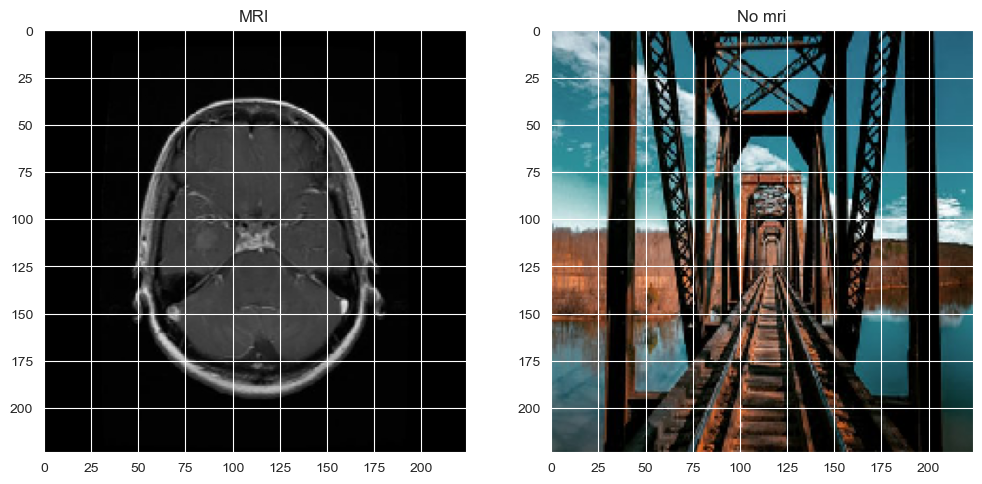

In [10]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(test_image1.squeeze())
plt.title("MRI")

plt.subplot(1,2,2)
plt.imshow(test_image2.squeeze())
plt.title("No mri")

plt.show()

In [11]:
class_labels = ["mri", "non mri"]

prediction1 = loaded_model.predict(test_image1)
prediction2 = loaded_model.predict(test_image2)

predicted_class_index1 = np.argmax(prediction1)
predicted_class_index2 = np.argmax(prediction2)

predicted_class_label1 = class_labels[predicted_class_index1]
predicted_class_label2 = class_labels[predicted_class_index2]

print("Prediction for test image 1 (MRI):", predicted_class_label1)
print("Prediction for test image 2 (Non-MRI):", predicted_class_label2)

2024-03-14 00:14:40.220567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 19ms/step
Prediction for test image 1 (MRI): mri
Prediction for test image 2 (Non-MRI): mri


In [12]:
predictions = loaded_model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes

2024-03-14 00:14:41.974072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 00:14:42.030241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


44/44 [==============================] - 21s 466ms/step


In [13]:
cm = confusion_matrix(true_classes, predicted_classes)

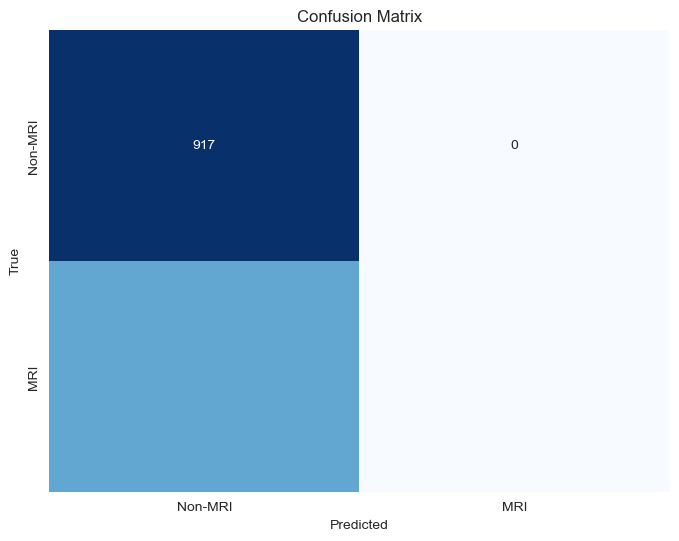

In [14]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5], labels=['Non-MRI', 'MRI'])
plt.yticks(ticks=[0.5, 1.5], labels=['Non-MRI', 'MRI'])
plt.show()

In [17]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("GPU details: ", details)

GPU details:  {'device_name': 'METAL'}
